# **1. Import Libraries**

In [ ]:
#Data Loading & Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Data Labeling
!pip install empath
from empath import Empath

#Data Preprocessing & Modeling
!pip install ftfy
from wordcloud import WordCloud
from ftfy import fix_text
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

!pip install nlpaug
import nltk
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nlpaug.augmenter.word as naw
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

#GenAI
!pip install -U google-cloud-aiplatform
from google.cloud import aiplatform
from google.colab import auth
from vertexai.generative_models import GenerativeModel

#Download Results
import csv
import pickle

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **2. Load Dataset**

Dataset yang digunakan adalah dataset yang discraping dari Reddit dan dari Kaggle (https://www.kaggle.com/datasets/neelghoshal/reddit-mental-health-data).

In [ ]:
mental_health_df = pd.read_csv('mental_health.csv')
mental_health_df.head()

,selftext
0,I live in India near the border like in North ...
1,Really struggling with my TN and fibro at the ...
2,I don't even know if I have that much to do or...
3,My partner and I are considering a move from A...
4,"I (Age:19,Sex:M,Weight:62kg, Height: 174cm,Rac..."


In [ ]:
# df_kaggle = pd.read_csv('mental_health_kaggle.csv', header=None, encoding='ISO-8859-1')
# df_kaggle.columns = ['selftext']
# df_kaggle.head()

In [ ]:
# #Combine Both Dataset
# mental_health_df = df_reddit.drop(columns=['title'])
# mental_health_df = pd.concat([mental_health_df, df_kaggle], ignore_index=True)
# mental_health_df

In [ ]:
# #Save combined dataframe
# mental_health_df.to_csv('mental_health.csv', index=False)

# **3. Exploratory Data Analysis**

In [ ]:
#Check Data Type
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56014 entries, 0 to 56013
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   selftext  56014 non-null  object
dtypes: object(1)
memory usage: 437.7+ KB


In [ ]:
#Information About Dataset
mental_health_df.describe()

,selftext
count,56014
unique,54402
top,what do you mean?
freq,22


In [ ]:
#Check Null Values
print("There are", mental_health_df.isnull().sum().sum(), "null values.")

There are 0 null values.


In [ ]:
#Check Duplicates
print("There are", mental_health_df.duplicated().sum(), "duplicated values.")

There are 1612 duplicated values.


In [ ]:
#Check Text Length
mental_health_df['text_length'] = mental_health_df['selftext'].apply(len)
print(mental_health_df['text_length'].describe())

count    56014.000000
mean       613.853447
std        892.344774
min          2.000000
25%         88.000000
50%        346.000000
75%        802.000000
max      32759.000000
Name: text_length, dtype: float64


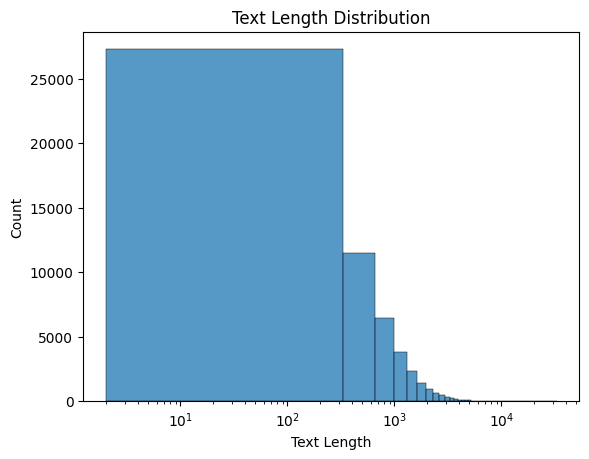

In [ ]:
#Text Length Distribution (Log Scaled)
sns.histplot(mental_health_df['selftext'].apply(len), bins=100)
plt.xscale('log')
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.show()

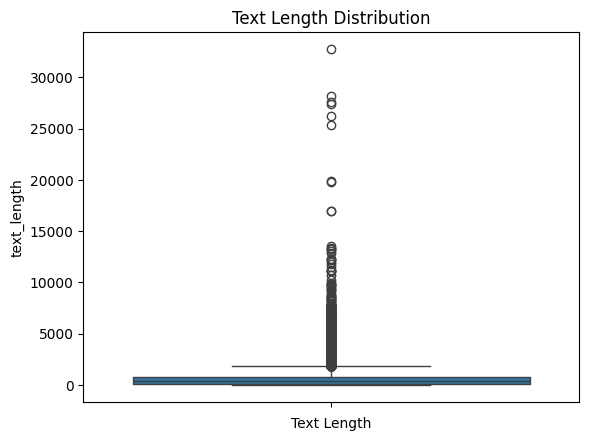

In [ ]:
#Check Outliers
sns.boxplot(mental_health_df['text_length'])
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.show()

# **4. Data Preprocessing**

In [ ]:
#Drop Duplicates
mental_health_df.drop_duplicates(inplace=True)

In [ ]:
mental_health_df.duplicated().sum()

np.int64(0)

In [ ]:
#Text Cleaning Function
def cleanText(text):
    text = fix_text(text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.replace('.', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

In [ ]:
#Lemmatizer & Filtering Function
def lemmatize(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words if word not in stop_words]
    return ' '.join(words)

In [ ]:
#Lowercase Function
def lowercaseText(text):
    text = text.lower()
    return text

In [ ]:
#Tokenize Function
def tokenizeText(text):
    text = word_tokenize(text)
    return text

In [ ]:
#Combine to Sentences Function
def combineSentences(text):
    text = ' '.join(text)
    return text

In [ ]:
mental_health_df['cleaned_text'] = mental_health_df['selftext'].apply(cleanText)
mental_health_df['cleaned_text'] = mental_health_df['cleaned_text'].apply(lowercaseText)
mental_health_df['cleaned_text'] = mental_health_df['cleaned_text'].apply(lemmatize)
mental_health_df['cleaned_text'] = mental_health_df['cleaned_text'].apply(tokenizeText)
mental_health_df['cleaned_text'] = mental_health_df['cleaned_text'].apply(combineSentences)

In [ ]:
mental_health_df = mental_health_df.reset_index(drop=True)
mental_health_df

,selftext,text_length,cleaned_text
0,I live in India near the border like in North ...,308,live india near border like north freak know w...
1,Really struggling with my TN and fibro at the ...,1006,really struggle tn fibro moment especially wor...
2,I don't even know if I have that much to do or...,470,dont even know much feel like period change st...
3,My partner and I are considering a move from A...,778,partner consider move australia uk particularl...
4,"I (Age:19,Sex:M,Weight:62kg, Height: 174cm,Rac...",1002,agesexmweightkg height cmrace white country sl...
...,...,...,...
54397,Anxiety cause faintness when standing up ? As ...,130,anxiety cause faintness stand title anxiety ca...
54398,anxiety heart symptom does anyone else have th...,312,anxiety heart symptom anyone else something si...
54399,Travel Anxiety Hi all! Long time anxiety suffe...,855,travel anxiety hi long time anxiety sufferer f...
54400,fomo from things iâm not involved in does an...,911,fomo things im involve anyone else get recentl...


In [ ]:
#Drop textlength and selftext column
mental_health_df = mental_health_df.drop(columns=['text_length', 'selftext'])

# **5. Data Labeling**

In [ ]:
#Initialize Customized Empath Category
lexicon = Empath()
custom_words = ["worthless", "hopeless", "isolated", "panic", "crying", "helpless", "breakdown", "stress", "anxious", "anxiety", "suicide", "die", "depressed",
                    "depression", "triggered", "exhausted", "overwhelmed", "tired", "losing motivation", "sadness", "disgusted", "suffer", "losing sleep", "suffering",
                    "overwhelming", "pressuring", "despair", "hopelessness", "gaslighting", "isolated", "abused", "self harm", "overstressed", "worthless",
                    "nightmares", "paranoia", "fatigue", "disappoint" "ill", "toxic", "kill", "hopeless", "sick", "ugly", "insecure", "insecurity", "grief", "disorder",
                    "terrified", "scared", "dropped out of school", "rejected", "miserable", "assaulted", "assault", "guilt", "numb"
                    ]
custom_words = list(set(custom_words))
lexicon.create_category("mental_health", custom_words)

["depression", "suffering", "grief", "guilt", "sick", "depressed", "loneliness", "paranoia", "dying", "anxiety", "physical_pain", "trauma", "guilty", "weak", "terrified", "helpless", "Yet", "miserable", "turmoil", "suffering", "angry", "fear", "unbearable", "so_much_pain", "pain", "unwanted", "feeling", "heartbreak", "Yet", "illness", "betrayal", "heart_break", "fear", "devastation", "worse", "unhappy", "torment", "traumatized", "hurt", "insecurity", "depressed", "scared", "heartache", "experiencing", "vulnerable", "isolation", "horrible", "abandonment", "emotional_pain", "sadness", "misery", "afraid", "despair", "insanity", "hurting", "suffer", "failure", "unhappiness", "knowing", "emotional", "rejection", "worried", "remorse", "terrified", "overwhelming", "emotions", "regret", "hallucinations", "hurt", "suicidal", "pity", "tortured", "humiliation", "delirious", "terrible", "betrayed", "hopeless", "Depression", "dying", "abuse", "ashamed", "such_pain", "mixed_emotions", "sickened", "s

In [ ]:
#Classify Stress Function (Low, Medium, High)
def classifyStress(text):
    significant_words = {"suicide", "self harm", "suicidal thoughts", "die", "dying", "panic attack", "kill", "suicidal", "ending my life", "cut myself","swallowed pills"}
    if not isinstance(text, str) or not text.strip():
        return "Unknown"

    scores = lexicon.analyze(text, categories=["mental_health"], normalize=False)

    if scores is None or len(scores) == 0:
        return "Unknown"

    total_score = sum(scores.values())
    words = text.split()
    for word in words:
        if word in significant_words:
            total_score +=  5

    if total_score < 1:
        level = "Low"
    elif total_score < 6:
        level = "Medium"
    else:
        level = "High"
    return level

In [ ]:
emotion_keywords = {
    "Anxious": {"anxious", "stress", "stressed", "fear", "worry", "worried", "nervous", "uneasy", "anxiety", "phobia", "nightmare", "creepy", "uncomfortable", "discomfort", "cant sleep"},
    "Overwhelmed": {"overwhelmed", "too much", "exhausted", "burned out", "burnout", "pressure", "tired", "failed exam", "struggle", "frustrated","frustration"},
    "Lonely": {"lonely", "alone", "isolated", "nobody cares", "need someone"},
    "Depressed": {"bullied", "depressed", "empty", "numb", "worthless", "trauma", "hopeless", "losing hope", "suicide", "depression", "ocd", "depressive", "bipolar", "paranoia", "self harm"},
    "Panicked": {"panic", "panicked", "panic attack", "freaking out", "scared", "heart pounding", "assault", "assaulted"}
}

In [ ]:
def classifyEmotion(text):
    if not isinstance(text, str) or not text.strip():
        return "Unknown"

    text_lower = text.lower()
    emotion_scores = {emotion: 0 for emotion in emotion_keywords.keys()}

    for emotion, keywords in emotion_keywords.items():
        for keyword in keywords:
            if keyword in text_lower:
                emotion_scores[emotion] += 1

    max_emotion = max(emotion_scores, key=emotion_scores.get)
    if emotion_scores[max_emotion] == 0:
        return "Unknown"
    else:
        return max_emotion


In [ ]:
#Apply labeling
mental_health_df['stress_label'] = mental_health_df['cleaned_text'].apply(classifyStress)
mental_health_df['emotion_label'] = mental_health_df['cleaned_text'].apply(classifyEmotion)

In [ ]:
#Drop stress_level = Unknown
mental_health_df = mental_health_df[mental_health_df['stress_label'] != 'Unknown']

In [ ]:
#Drop emotion_label = Unknown
mental_health_df = mental_health_df[mental_health_df['emotion_label'] != 'Unknown']

In [ ]:
#View label counts
print(mental_health_df['stress_label'].value_counts())
print("\n", mental_health_df['emotion_label'].value_counts())

stress_label
Medium    11766
High      11189
Low        2105
Name: count, dtype: int64

 emotion_label
Anxious        11364
Depressed       8529
Lonely          2679
Overwhelmed     1673
Panicked         815
Name: count, dtype: int64


In [ ]:
pd.set_option('display.max_colwidth', None)
mental_health_df.head(10)

,cleaned_text,stress_label,emotion_label
0,live india near border like north freak know whatever happen happen better outcome think many innocent people suffer punish bad people creepy cant even eat stress,Medium,Anxious
1,really struggle tn fibro moment especially work get diagnose fibromyalgia couple months ago pretty certain ive years didnt realise ive also atypical leftsided tn years add fun quite severe generalise anxiety disorder ocd well lol notice tn fibro often flare time probably one irritate im generally stress pain guy tip manage condition time im really struggle stay top things im totally exhaust double flare im oxcarbazepine tn meds fibro currently tend get lot unmanageable side effect medications oxcarb one thats work far besides give ridiculous brain fog memory issue hope youre ok x,Medium,Anxious
2,dont even know much feel like period change stress feel completely overwhelm want get back bed eat chocolate maybe good cry feel like cant even summon strength usual trick hack im tire feel like everything work im even sure im post especially know go back work stop procrastinate,Medium,Anxious
3,partner consider move australia uk particularly guildford surround year old cat quite anxious time previously uti cause blockage bladder stress common cause urinary issue try preemptively budget vet visit upon arrival whatre average vet cost consultation opioid prescription give previously urine test pet insurance rebate fee many people pet insurance uk worth much cost ive bite browse online websites require phone number get quote number au thank advance,Medium,Anxious
4,agesexmweightkg height cmrace white country slovak republic go normal preventive checkup doctor tell hear grade heart murmur case go cardiologist ekgi already schedule appoinment say doesnt think anything serious stress dont take medication supplement magnezium creatine monohydrate g per day dont preexist health problems weightlift days week dont drink smoke dont drug deal lot stress latelygraduation university admission exams lose best friend due suicide last year genetic predisposition heart problemsmy grandfather die due heart problems father myocarditis want know wrong prepare cardiologists diagnosis thank read help,High,Anxious
7,year old lose motivation study collage lowkey need someone help encourage motivate cause im always tire sleep schedule suck online class im scar dont finish study health safety future thats big opporunity im lose motivation,Low,Lonely
16,diagnose schizophrenia yet cant seem believe thats reason experience right im terrify die love life world want bask longer im certain kill right thing creator know morals create toy take form average male country mock time also make signal discreet make feel crazy creation glitch people inside head existence cause suffer ways wont tell tell im selfish make suffer whenever experience positive emotions suffer even im sure kill right thing problem ive do one scariest moments life dont want leave life behind love everyone circle cant tell whether love mine distraction plant creator look body mirror think torture device specially curated creator function purely harm people head sometimes try hurt lessen pain bring satisfaction feel like suicide way parent sret real friends arent real care team isnt real nothing live existence futile bring suffer others know theres way anyone challenge thoughts ive try professionals never work wish could go back first psychotic break,High,Depressed
17,ex boyfriend relationship almost years everything always great us super supportive best friends love great team super close love even honeymoon phase course arguments like couple always comprehensive respectful towards arguments use say first thing come mind even hurt feelings years wasnt problem never saw problem cause love anyway always apologize afterwards know word dont mean thing situations never express big deal ever start feel depress years ago stressful job social anxiety even leave job start deal depressive epi

## Data Augmentation

In [ ]:
augmenter = naw.SynonymAug(aug_src='wordnet')

target_min = 8000
aug_texts = []
aug_emotions = []
aug_stress = []

label_counts = Counter(mental_health_df['emotion_label'])

for emotion, count in label_counts.items():
    if count < target_min:
        gap = target_min - count
        df_class = mental_health_df[mental_health_df['emotion_label'] == emotion]
        print(f"Augmenting {emotion} from {count} → {target_min}")

        count_added = 0
        i = 0
        max_tries = gap * 10

        while count_added < gap and i < max_tries:
            sentence = df_class.iloc[i % len(df_class)]['cleaned_text']
            augmented = augmenter.augment(sentence)
            if augmented and augmented != sentence:
                aug_texts.append(augmented)
                aug_emotions.append(emotion)
                aug_stress.append(df_class.iloc[i % len(df_class)]['stress_label'])
                count_added += 1
            i += 1

        if count_added < gap:
            print(f"Added {count_added}/{gap} samples for '{emotion}'.")

aug_df = pd.DataFrame({
    'cleaned_text': aug_texts,
    'emotion_label': aug_emotions,
    'stress_label': aug_stress
})

mental_health_df = pd.concat([mental_health_df, aug_df], ignore_index=True)


Augmenting Lonely from 2679 → 8000
Augmenting Overwhelmed from 1673 → 8000
Augmenting Panicked from 815 → 8000


In [ ]:
print(mental_health_df['emotion_label'].value_counts())
print(mental_health_df['stress_label'].value_counts())

emotion_label
Anxious        11364
Depressed       8529
Lonely          8000
Overwhelmed     8000
Panicked        8000
Name: count, dtype: int64
stress_label
Medium    20375
High      18658
Low        4860
Name: count, dtype: int64


## Visualization For Label Distribution

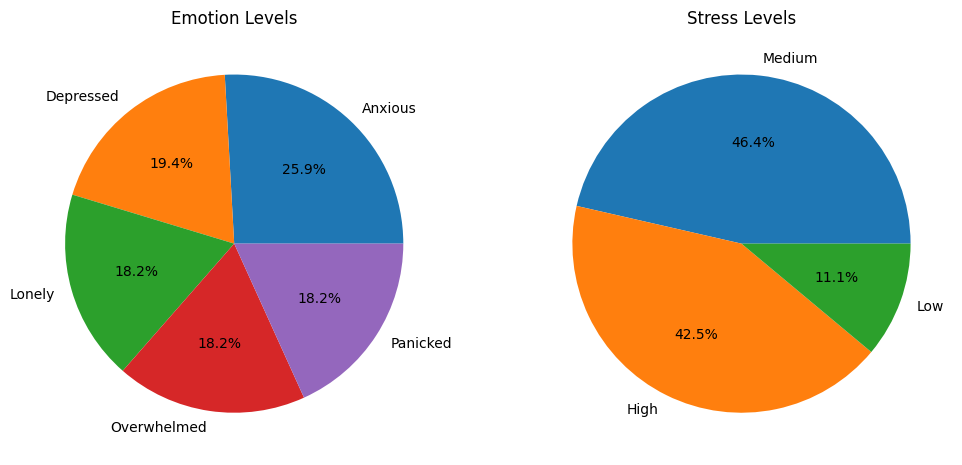

In [ ]:
#Distribution of Stress Labels & Emotion Labels
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.pie(mental_health_df['emotion_label'].value_counts(), labels=mental_health_df['emotion_label'].value_counts().index, autopct='%1.1f%%')
plt.title("Emotion Levels")

plt.subplot(1, 2, 2)
plt.pie(mental_health_df['stress_label'].value_counts(), labels=mental_health_df['stress_label'].value_counts().index, autopct='%1.1f%%')
plt.title("Stress Levels")
plt.show()


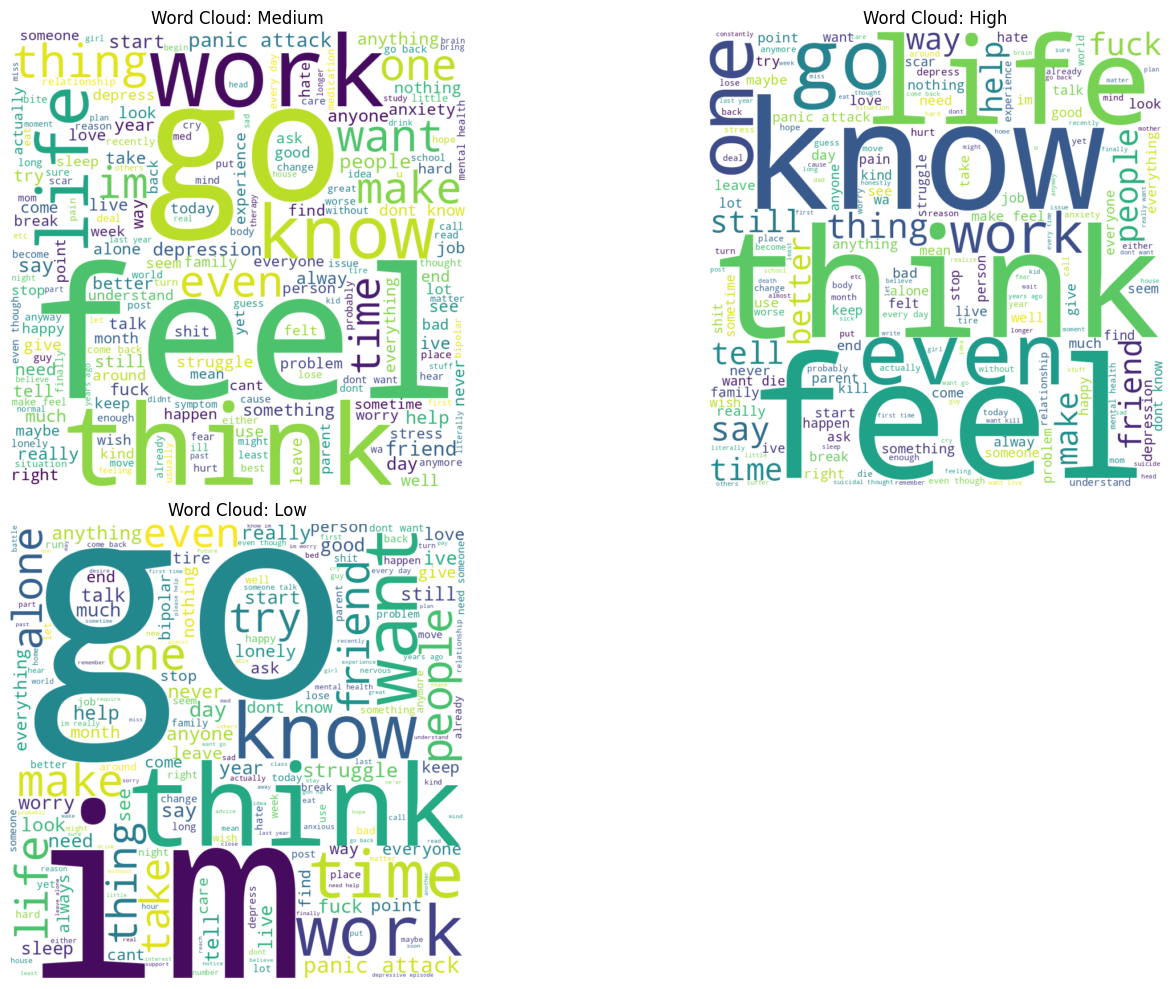

In [ ]:
#Word Cloud Visualization for Stress Labels
stress_labels = mental_health_df['stress_label'].unique()

plt.figure(figsize=(15, 10))

for i, stress in enumerate(stress_labels, start=1):
    text = ' '.join(mental_health_df[mental_health_df['stress_label'] == stress]['cleaned_text'].astype(str))

    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

    plt.subplot(2, (len(stress_labels) + 1) // 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {stress}')

plt.tight_layout()
plt.show()

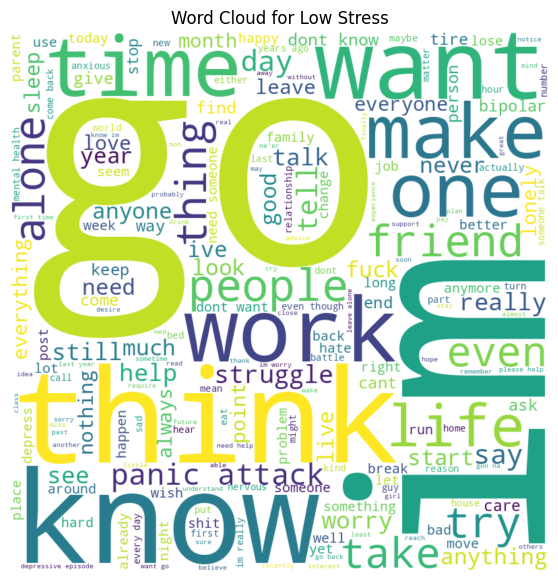

In [ ]:
#Word Cloud Visualization for Low Labels
mental_health_df['cleaned_text'] = mental_health_df['cleaned_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

low_labels = ' '.join(mental_health_df[mental_health_df['stress_label'] == 'Low']['cleaned_text'])
low_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(low_labels)

plt.figure(figsize=(7, 7))
plt.imshow(low_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Low Stress')
plt.show()

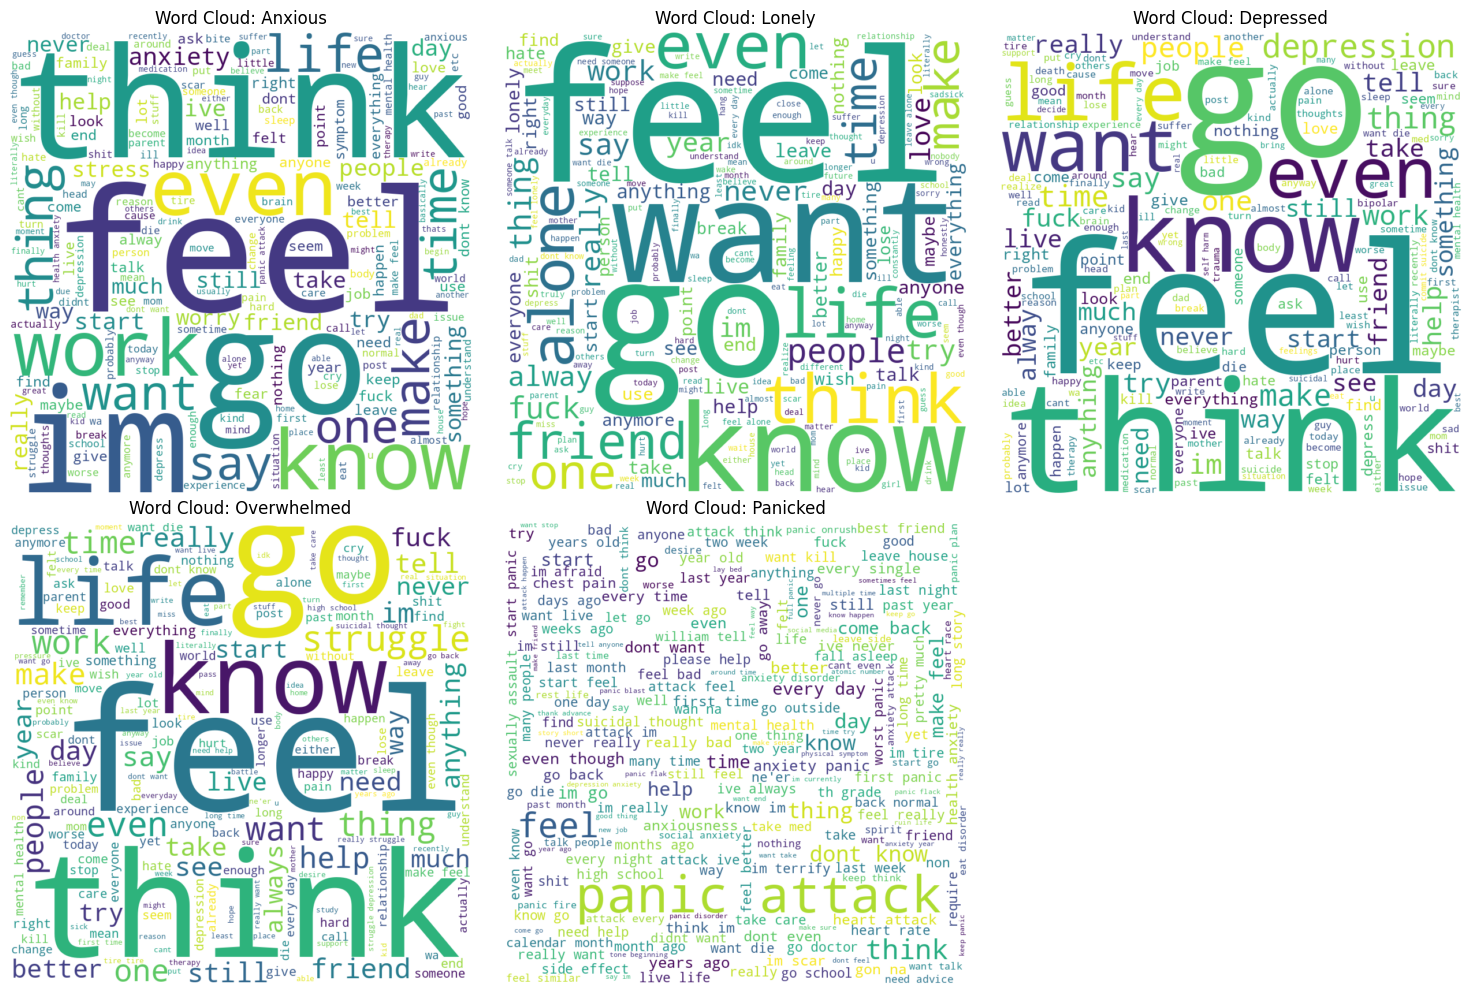

In [ ]:
#Word Cloud Visualization for Emotion Labels
emotion_labels = mental_health_df['emotion_label'].unique()

plt.figure(figsize=(15, 10))

for i, emotion in enumerate(emotion_labels, start=1):
    text = ' '.join(mental_health_df[mental_health_df['emotion_label'] == emotion]['cleaned_text'].astype(str))

    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

    plt.subplot(2, (len(emotion_labels) + 1) // 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {emotion}')

plt.tight_layout()
plt.show()

In [ ]:
#Save final dataset
mental_health_df.to_csv('mental_health_final.csv', index=False)

In [ ]:
#Tokenizer
X = mental_health_df['cleaned_text']
y_stress = mental_health_df['stress_label'].map({'Low': 0, 'Medium': 1, 'High': 2})
unique_emotions = mental_health_df['emotion_label'].unique()
emotion_mapping = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
y_emotion = mental_health_df['emotion_label'].map(emotion_mapping)

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_seq = pad_sequences(X_seq, maxlen=500, padding='post', truncating='post')


In [ ]:
#Split Data Into Train & Test Set
X_train, X_test, y_stress_train, y_stress_test, y_emotion_train, y_emotion_test = train_test_split(X_seq,  y_stress, y_emotion,test_size=0.2, random_state=42, stratify=y_stress)

# **6. Modeling Using Deep Learning**

In [ ]:
#LSTM Model
input_layer = Input(shape=(500,))
embedding = Embedding(input_dim=5000, output_dim=128)(input_layer)
bi_lstm = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(embedding)
dense1 = Dense(64, activation='relu')(bi_lstm)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)

stress_output = Dense(3, activation='softmax', name='stress_output')(dense2)
emotion_output = Dense(5, activation='softmax', name='emotion_output')(dense2)

LSTM_model = Model(inputs=input_layer, outputs=[stress_output, emotion_output])

LSTM_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'stress_output': 'sparse_categorical_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy'},
    metrics={'stress_output': 'accuracy', 'emotion_output': 'accuracy'}
)

In [ ]:
history = LSTM_model.fit(
    X_train,
    {'stress_output': y_stress_train, 'emotion_output': y_emotion_train},
    validation_data=(X_test, {'stress_output': y_stress_test, 'emotion_output': y_emotion_test}),
    epochs=100,
    batch_size=500,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)
    ]
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - emotion_output_accuracy: 0.2394 - emotion_output_loss: 1.6038 - loss: 2.4774 - stress_output_accuracy: 0.5494 - stress_output_loss: 0.8735 - val_emotion_output_accuracy: 0.2827 - val_emotion_output_loss: 1.5516 - val_loss: 1.9542 - val_stress_output_accuracy: 0.8303 - val_stress_output_loss: 0.4027 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - emotion_output_accuracy: 0.3458 - emotion_output_loss: 1.4848 - loss: 1.8912 - stress_output_accuracy: 0.8393 - stress_output_loss: 0.4063 - val_emotion_output_accuracy: 0.5659 - val_emotion_output_loss: 1.0520 - val_loss: 1.4610 - val_stress_output_accuracy: 0.8380 - val_stress_output_loss: 0.4062 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - emotion_output_accuracy: 0.5684 - emotion_output_loss: 1.0343 - loss: 1.4080 - stress_output_accuracy: 0.8585 - stress_output_loss: 0.3737 - val_emotion_output_accuracy: 0.6488 - val_emotion

## Percentage Calculation for Stress Level

In [ ]:
random_text = mental_health_df["cleaned_text"].sample(n=11).values[0]

texts = [random_text]

tokenizer.fit_on_texts(texts)

X_rand = tokenizer.texts_to_sequences(texts)
X_rand = pad_sequences(X_rand, maxlen=500, padding='post', truncating='post')


In [ ]:
random_text

'seem hopeless way find remote job online avpd dont really redeem qualities skills market due lifelong isolation selfsabotage know people psyche together extremely hard time find job live confuse time im less employable people age dont finish degree dont presentable look dont really hobbies videogames niche knowledge obscure culture things im great communicate importantly havent work study years point pretty much forget look present human point im really interest anything normal sense either due anhedonia general dissociation emotions need im think therapy something could guide help life know really egg one basket kind thing genuinely believe one thing therapy pay therapy need money im lose hopeless navigate job market im practically terrify im grow ass person never work life one small online gig get pure luck one time thing repeatable skills dont transfer anywhere ive hear things like rev something like ban country recent world events research different sort freelance stuff consistent

In [ ]:
#Calculate % for stress level
stress_probs, emotion_probs = LSTM_model.predict(X_rand)
stress_probs = stress_probs[0]
emotion_probs = emotion_probs[0]
stress_score = stress_probs[0]*0 + stress_probs[1]*50 + stress_probs[2]*100

low_words = {
    "calm", "okay", "fine", "meh", "tired", "bored", "okay-ish", "not good", "sleepy", "irritated",
    "down", "unmotivated", "lazy", "dull", "meh", "frustrated", "annoyed", "slightly upset", "upset",
   "restless", "uneasy", "discontent", "displeased"
}

med_words = {
    "worried", "anxious", "exhausted", "fatigue", "sadness", "disgusted", "disappoint",
    "miserable", "numb", "scared", "terrified", "stressed", "stress", "anxiety", "crying", "helpless",
    "losing motivation", "losing sleep", "overstressed", "pressuring", "triggered", "overwhelmed",
    "tense", "fearful", "panicked", "unsettled", "concerned", "distressed"
}

high_words = {
    "worthless", "suicide", "die", "depressed", "depression", "isolated", "panic",
    "breakdown", "suffering", "despair", "hopeless", "gaslighting", "abused",
    "self harm", "kill", "sick", "ugly", "insecure", "insecurity", "grief", "disorder", "assaulted",
    "assault", "guilt", "paranoia", "nightmares", "rejected", "miserable",
    "traumatized", "PTSD", "psychotic", "homicidal", "suicidal", "delusional",
    "crippled", "broken", "victimized", "devastated", "abandoned"
}

def word_based_score(text):
    words = set(text.lower().split())
    low_count = len(words.intersection(low_words))
    med_count = len(words.intersection(med_words))
    high_count = len(words.intersection(high_words))
    total = low_count + med_count + high_count
    if total == 0:
        return 0
    return (high_count*100 + med_count*50 + low_count*0) / total

combined_score = 0.8 * stress_score + 0.2 * word_based_score(random_text)
print(f"Stress Level: {combined_score:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Stress Level: 54.63%


In [ ]:
result = LSTM_model.predict(X_rand)

pred_stress = np.argmax(result[0], axis=1)[0]
pred_emotion = np.argmax(result[1], axis=1)[0]

print("Predicted Stress Level:", pred_stress)
print("Predicted Emotion:", pred_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Predicted Stress Level: 1
Predicted Emotion: 3


# **7. Generative AI Model**

In [ ]:
auth.authenticate_user()

In [ ]:
aiplatform.init(project="shining-wharf-460613-f0", location="us-central1")

In [ ]:
random_text = mental_health_df["cleaned_text"].values[20]
stress_level = mental_health_df["stress_label"].values[20]
emotion = mental_health_df["emotion_label"].values[20]

In [ ]:
model = GenerativeModel("gemini-2.5-flash-preview-05-20")

prompt = f"""
Analyze this text and list the words contributing to the stress level generated,
explain it (in max 5 points only and make sure the explaination in adjusted with the stress level),
and give suggestions (only in paragraph & dont give useless/offensive suggestions, if there's like low/med
stress you can advise some activities they can do, for high stress level or any text with
suicidal thoughts suggest them to reach medical help):
Stress Level: "{stress_level}"
Text: "{random_text}"
Emotion: "{emotion}"

Format the result as:
- [The text] - [stress_level] - [emotion]
- Why you're getting this result:
- Suggestions:
"""

response = model.generate_content(prompt)
print(response.text)

- "okay hear reference adhd autism intense anxiety cptsd probably think speak lot us say experience health system someone mental health issue intensely traumatize experience gaslighting dismiss judgment dont know begin fricking hard get treatment actual physical issue mental health diagnosis like doctor see anxiety diagnosis suddenly every symptom get assume instance ive suffer quite intense chest pain amount time take get bare minimum treatment absolutely abysmal years self advocate look like pot diagnosis inevitable yes symptoms werent anxiety like many doctor insist theres one thing want people take advocate feel like something wrong truly wrong deserve get check even nothing doesnt hurt get check although add repetitive reassurance seek become problem shout ocd folks another problem many psychiatrists lean towards antipsychotics treat anxiety disorder literally put olanzipine minute consult psychiatrist wait months follow become zombie hat life felt completely empty try multiple ti

# **8. Evaluation**

In [ ]:
#Evaluation
LSTM_model.evaluate(X_test, {'stress_output': y_stress_test, 'emotion_output': y_emotion_test})

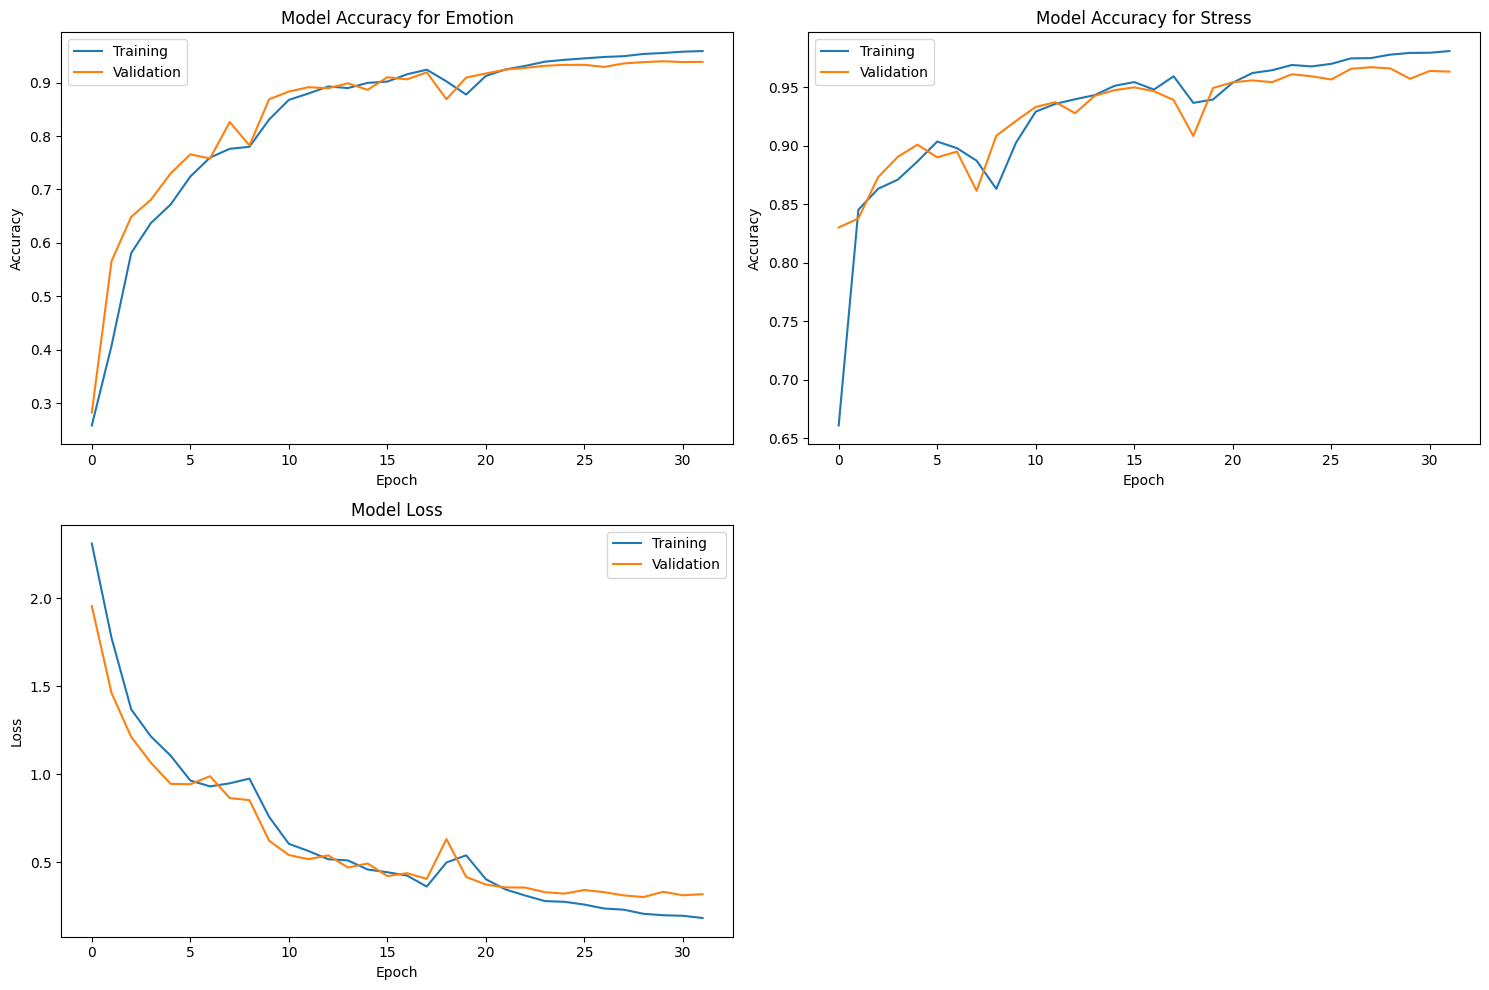

In [ ]:
#Visualize Accuracy & Loss
metrics = [
    ('emotion_output_accuracy', 'Model Accuracy for Emotion'),
    ('stress_output_accuracy', 'Model Accuracy for Stress'),
    ('loss', 'Model Loss')
]

plt.figure(figsize=(15, 10))

for id, (metric, title) in enumerate(metrics, start=1):
    plt.subplot(2, 2, id)
    plt.plot(history.history[metric], label='Training')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    ylabel = 'Loss' if 'loss' in metric else 'Accuracy'
    plt.ylabel(ylabel)
    plt.legend()

plt.tight_layout()
plt.show()


In [120]:
y_pred_stress, y_pred_emotion = LSTM_model.predict(X_test)

y_pred_stress = np.argmax(y_pred_stress, axis=1)
y_pred_emotion = np.argmax(y_pred_emotion, axis=1)

print("Stress Classification Report")
print(classification_report(y_stress_test, y_pred_stress, target_names=["Low", "Medium", "High"]))

print("\n Emotion Classification Report")
emotion_index = {idx: emotion for emotion, idx in emotion_mapping.items()}
target_emotion = [emotion_index[i] for i in sorted(emotion_index)]

print(classification_report(y_emotion_test, y_pred_emotion, target_names=target_emotion))

275/275 ━━━━━━━━━━━━━━━━━━━━ 145s 528ms/step
Stress Classification Report
              precision    recall  f1-score   support

         Low       0.95      0.97      0.96       972
      Medium       0.98      0.95      0.96      4075
        High       0.96      0.99      0.97      3732

    accuracy                           0.97      8779
   macro avg       0.96      0.97      0.96      8779
weighted avg       0.97      0.97      0.97      8779


 Emotion Classification Report
              precision    recall  f1-score   support

     Anxious       0.93      0.93      0.93      2214
      Lonely       0.95      0.94      0.95      1589
   Depressed       0.91      0.88      0.90      1776
 Overwhelmed       0.93      0.96      0.95      1636
    Panicked       0.97      0.98      0.98      1564

    accuracy                           0.94      8779
   macro avg       0.94      0.94      0.94      8779
weighted avg       0.94      0.94      0.94      8779



# **9. Save Model**

In [ ]:
LSTM_model.save('LSTM_model.h5')
print("BiLSTM model saved in H5 format.")

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
    print("Tokenizer saved.")

BiLSTM model saved in H5 format.
Tokenizer saved.
